<a href="https://colab.research.google.com/github/janetttliu/QAPOTM2/blob/main/No_Battery_CarbonDensities_of_M2_13_11_2025_QAPOT_25_26_Aug_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Aerosandbox
Run the cell below when you open this file or if you restart the kernel/session

In [ ]:
!pip install aerosandbox

# Creating power and thrust fit from prop chart
Run the cell below when you open this file or if you restart the kernel/session

In [ ]:
import pandas as pd
import numpy as np
from casadi import MX, vertcat, Function

def load_prop_data(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    data_blocks = []
    current_rpm = None
    i = 0
    while i < len(lines):
        line = lines[i]
        if "PROP RPM" in line:
            try:
                current_rpm = float(line.split("=")[1])
            except:
                i += 1
                continue

            if current_rpm < 5000:
                i += 1
                continue

            i += 3
            while i < len(lines) and lines[i].strip():
                parts = lines[i].split()
                if len(parts) < 12:
                    i += 1
                    continue
                try:
                    v_mph = float(parts[0])
                    power_W = float(parts[8])
                    thrust_N = float(parts[10])
                except ValueError:
                    i += 1
                    continue

                data_blocks.append({
                    "v": v_mph * 0.44704,  # m/s
                    "rpm": current_rpm,
                    "power": power_W,
                    "thrust": thrust_N
                })
                i += 1
        else:
            i += 1

    return pd.DataFrame(data_blocks)


def fit_separable_polynomial(df, y_col, deg_v=5, deg_rpm=3):
    """
    Fit separable polynomial: y = sum(a_i*v^i) + sum(b_j*rpm^j)
    Returns: a_coeffs, b_coeffs
    """
    v = df["v"].values
    rpm = df["rpm"].values
    y = df[y_col].values

    # Design matrix: powers of v and powers of rpm
    X = np.column_stack([v**i for i in range(deg_v+1)] +
                        [rpm**j for j in range(deg_rpm+1)])

    coeffs, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    a_coeffs = coeffs[:deg_v+1]
    b_coeffs = coeffs[deg_v+1:]
    return a_coeffs, b_coeffs


def build_casadi_poly(a_coeffs, b_coeffs):
    """
    Build CasADi expression for separable polynomial
    """
    v = MX.sym('v')
    rpm = MX.sym('rpm')

    expr_v = sum(a*v**i for i, a in enumerate(a_coeffs))
    expr_rpm = sum(b*rpm**j for j, b in enumerate(b_coeffs))
    expr = expr_v + expr_rpm

    # Optional: make CasADi function for fast evaluation
    f = Function('poly_func', [v, rpm], [expr])
    return f


def build_prop_model(df, deg_v=5, deg_rpm=3):
    # Fit power
    a_p, b_p = fit_separable_polynomial(df, "power", deg_v, deg_rpm)
    # Fit thrust
    a_t, b_t = fit_separable_polynomial(df, "thrust", deg_v, deg_rpm)

    # Build CasADi functions
    power_func = build_casadi_poly(a_p, b_p)
    thrust_func = build_casadi_poly(a_t, b_t)

    return power_func, thrust_func, (a_p, b_p), (a_t, b_t)



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       38
Number of nonzeros in Lagrangian Hessian.............:       39

Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       17
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        9
        inequality constraints with only upper bounds:        5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -4.0000000e+00 1.24e+00 9.64e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

        Wingspan =  1.50 m
           Chord =  0.38 m
           Taper =  0.60
   Planform area =  0.56 m^2
    Aspect Ratio =  4.00
   Aircraft Mass =  4.04 kg
  B/n tail booms =  0.78 m
  M2 Net Income = 342.25 $
  Energy Cap =  71 Wh
        Laps =  9
  lapeffective =  730 m
  Weight Empty =  3.36 kg


       Cruise CL =  0.21
      Cruise AOA =  0.2
        Flaps CL =  1.86
       Flaps AOA =  8.0


        P-number =  1
   Usable Energy =  49.62 Wh
   Propeller PRM =  8770 RPM
       Power Req =  123 W
 Power from Prop =  291 W
            Drag =  5.0 N
          Thrust =  5.0 N
     Corner Drag =  28.0 N
     Loiter Drag =  9.3 N
     Loiter Lift =  39.6 N


     Cruise time =  10.23 minutes
 Cruise airspeed =  24.6 m/s
 Corner airspeed =  16.3 m/s maximum with flaps
 Loiter airspeed =  9.4 m/s
    Cruise Range =  15079 m
Cornering Radius =  10 m minimum
      Bank Angle =  71 deg maximum


         Tail Length =  0.58 m
       Static Margin =  12.0
            LE to NP =  0.13 m
    LE to desired CG =  0.08 m
Tail Horiz Vol Coeff =  0.254
     Tail Horiz Area =  0.109 m^2
 Tail Vert Vol Coeff =  0.025
      Tail Vert Area =  0.036 m^2
          Tail chord =  0.140 m
          Tail Vertical span =  0.3
           Tail Span =  0.78 m


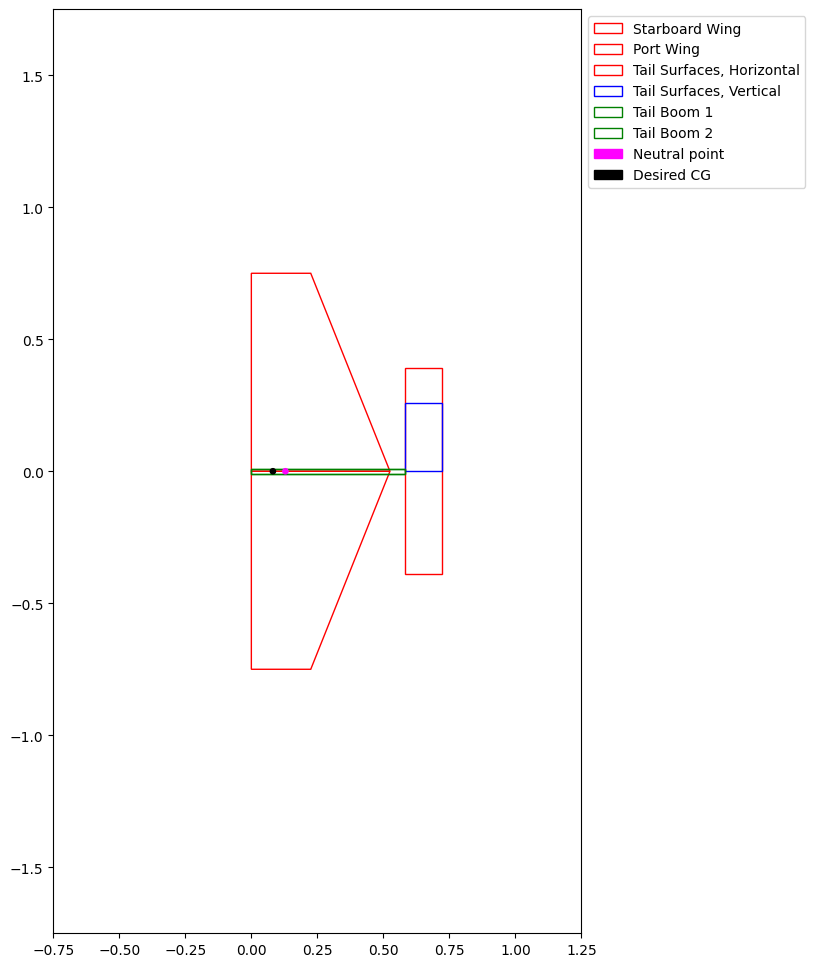

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Welcome to QAPOT - Queen's Aircraft Performance Optimization Tool

Created on Wed Nov 29 22:26:35 2023
MODIFIED for M2 AIAA 2026 by J.Liu

@author: Will Conway
"""
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
from IPython.display import display, HTML

opti = asb.Opti()  # initialize optimization environment

### Constants - CHANGE THESE TO DESIGN AIRCRAFT

    # Atmospheric Constraints
rho = 1.225  # standard day air density - kg/m^3 Do not touch!
mu = 1.81e-5  # dynamic viscosity of the air - kg/(m·s) Do not touch!
g = 9.8  # gravitational constant - m/s^2 Do not touch!

    # Aircraft Design Characteristics - VSPAERO stuff needs to change
Cd_f0 = 0.00263  # INPUT: Fuselage Drag coefficient as calculated in VSPAERO (USE WING REF AREA for Calc)
Cd_w0 = 0.01070 #0.01  # Wing parasitic drag coefficient as calculated in VSPAERO
Cd_t0 = 0.00309 #0.003  # Tail parasitic drag coefficient as calculated in VSPAERO
fus_width = 0.15  # INPUT width of fuselage (reduces lifting section of wing span)

Cl_max = 1.5  # stall condition (this should be at takeoff or VTOL transition)
#v_min = 8  # m/s stall condition (this should be at takeoff or VTOL transition speed)
#thicc  = 0.12  # Thickness of airfoil as % of chord
ARh = 6  # Horizontal Stab Aspect Ratio
ARv = 3  # Vertical Stab Aspect Ratio
e = 0.8  # Oswalds efficiency, generally accepted value
tail_type = 'c' #THISPART TOO!!!


    # Mission Params
time_total = 330 # INPUT s (5 min flight time window+30s)
energy_cap_limit = 100 # Wh
throttle_cruise = 0.7 # what throttle setting (0-1) we want to cruise at

    # Aircraft Material Properties
LdSpar = 0.124 # Linear density of spar materials. This should be kg/m FROM LUKE
LdSparTail = 0.044336 # Linear density of tail spar materials. This should be kg/m FROM LUKE
LdRib = 3.4 # Linear density of rib materials. This should be kg/m^2
RibsPerSpan = 6 # Number of wing ribs per meter
CoveringDensity = 0.75 # Weight of skin material. This should be in kg/m^2
foamdensity = 0 # density of foam used for inner section. This should be in kg/m^3

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_     DESIGN VARIABLES - Variables we want to find    #_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_

AR = opti.variable(init_guess=10)
ARh = opti.variable(init_guess=7)
S = opti.variable(init_guess=0.75)
Ltail = opti.variable(init_guess=1)
c_tail = opti.variable(init_guess=0.2)
v = opti.variable(init_guess=20)
alpha_g = opti.variable(init_guess=2)
alpha_g_flaps = opti.variable(init_guess=2)
#duck_number =  opti.variable(init_guess=6)
laps = opti.variable(init_guess=4)
#Ah_per_cell = opti.variable(init_guess=4.5)

# Now apply bounds as constraints:
opti.subject_to([
    opti.bounded(4, AR, 15),
    opti.bounded(4, ARh, 10),
    opti.bounded(0.05, S, 1.5),
    opti.bounded(0.1, Ltail, 2.0), #double check variable name
    opti.bounded(0.14, c_tail, 0.4),
    opti.bounded(5, v, 40),
    opti.bounded(-2, alpha_g, 8),
    opti.bounded(-2, alpha_g_flaps, 8),
    #opti.bounded(3, duck_number, 9),
    opti.bounded(3, laps, 20),
    #opti.bounded(0, Ah_per_cell, 10),
])

taper_ratio = 0.6


# __=__=__=__=__=__=__=__=__=__=__=__=__=__=   BATTERY INFORMATION   __=__=__=__=__=__=__=__=__=__=__=__=__=__=__=__=__=__=

#https://www.18650batterystore.com/en-ca/products/molicel-p45b
p_number = 1  # how many 6s groups wired in parallel
volts_per_cell = 3.6
volts_tot = volts_per_cell * 6 # using 6s battery
Ah_per_cell = 3.3
prop_number = 2 #new cuz dual prop
energy_cap = volts_tot * Ah_per_cell * p_number # Wh,

EF = energy_cap/100 #3.3.3.2

#weight_per_cell = 1740/1000 * g # N per cell
#weight_battery = 6 * p_number * weight_per_cell
weight_per_battery = 525/1000 * g # N per battery
weight_battery = weight_per_battery

A_per_cell = 45

power_max_elec = volts_per_cell * 6 * A_per_cell * p_number
weight_per_duck = 0.0198447 #kgrams per duck, .7oz 3.1.2
weight_per_puck = 0.170097 #kgrams per puck. 6 oz  3.1.2
duck_number = 9
puck_number = duck_number / 3 # one puck per 3 ducks
weight_electronics = 1017.6/1000 #kg from SYSTEMS

    # Payload + Weights Properties
weight_fixed = weight_electronics*g + weight_battery + (weight_per_duck*duck_number + weight_per_puck*puck_number) * g  # N, 1.0176 kg fixed component weights + battery weight, M2 RN
energy_elec = 3  # W, 3 watts continuous for receiver and rate gyro - should be updated (PROPULSION BATTERIES ARE SEPERATE THERE WOULD BE NO DRAW FROM PROPULSION BATTERIES)


# {}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}  ANGLE OF ATTACK AND COEFFICIENT OF LIFT  {}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}

# FILL IN these based on airfoilTools or XFLR5
# currently using NACA 2412 - http://www.airfoiltools.com/polar/details?polar=xf-naca2412-il-500000

a_o = 5.967  # 2d lift curve slope - should really make this a function that finds the slope.
alpha_zero = np.deg2rad(2.25)  # angle of attack at 2d CL = 0 ... ideally this should be not hardcoded, like Cl_range....

# uncomment line below if not optimizing taper
# Cla = 0.1043 # in degrees using excel trendline - slope for angle of attack to coefficient of lift
# CLa = Cla / (1 + Cla/(np.pi * AR))
# Cl_cruise = CLa*alpha_g + 0.2508  # got equation using excel trendline - good up to 10 deg.

airfoil_choice = 1;

if airfoil_choice == 1: #2412
    a_o = 5.116513  #2D lift curve slope in rad
    alpha_zero = np.deg2rad(1.78)  # Zero-lift angle in radians
    Cla = 0.1097  #Lift slope in degrees
    offset = 0.194  #Offset for Cl calculation
    Cl_max = 1.25
    Stall_aoa = 11.97 #degrees
    thicc = 0.12
    #flaps
    a_o_flaps = 4.77  #2D lift curve slope in rad
    alpha_zero_flaps = np.deg2rad(14.5)  # Zero-lift angle in radians
    Cla_flaps = 0.0833  #Lift slope in degrees
    offset_flaps = 1.2  #Offset for Cl calculation
    Cl_max_flaps = 1.76
    Stall_aoa_flaps = 8.9


elif airfoil_choice == 2: #23012
    a_o = 4.967544
    alpha_zero = np.deg2rad(3.03)
    Cla = 0.0893
    offset = 0.271
    Cl_max = 1.30
    Stall_aoa = 12.9
    thicc = 0.12
    #flaps
    a_o_flaps = 4.62
    alpha_zero_flaps = np.deg2rad(15.37)
    Cla_flaps = 0.0807
    offset_flaps = 1.24
    Cl_max_flaps = 1.95
    Stall_aoa_flaps = 8.78

elif airfoil_choice == 3: #23015
    a_o = 4.967544
    alpha_zero = np.deg2rad(3.591)
    Cla = 0.0867
    offset = 0.3145
    Cl_max = 1.05
    Stall_aoa = 10.07
    thicc = 0.15
     #flaps
    a_o_flaps = 4.27
    alpha_zero_flaps = np.deg2rad(15.29)
    Cla_flaps = 0.0746
    offset_flaps = 1.14
    Cl_max_flaps = 1.97
    Stall_aoa_flaps = 11.1

elif airfoil_choice == 4: #4412
    a_o = 6.388479
    alpha_zero = np.deg2rad(3.513)
    Cla = 0.1115
    offset = 0.3918
    Cl_max = 1.36
    Stall_aoa = 9.91
    thicc = 0.12
    #flaps
    a_o_flaps = 4.07
    alpha_zero_flaps = np.deg2rad(18.09)
    Cla_flaps = 0.0711
    offset_flaps = 1.29
    Cl_max_flaps = 1.79
    Stall_aoa_flaps = 7.1

elif airfoil_choice == 5: #6409
    a_o = 7.191
    alpha_zero = np.deg2rad(4.23)
    Cla = 0.1255
    offset = 0.5316
    Cl_max = 1.50
    Stall_aoa = 8.5
    #the lift curve with flaps is too crazy to use
    thicc = 0.09

elif airfoil_choice == 6: #N10
    a_o = 5.807  #2D lift curve slope in rad
    alpha_zero = -0.1045  # Zero-lift angle in radians
    Cla = 0.10136 #Lift slope in degrees
    offset = 0.607  #Offset for Cl calculation
    Cl_max = 1.436
    Stall_aoa = 11.5 #degrees
    thicc = 0.12

# Calculate CLa with the selected Cla value
CLa = Cla / (1 + Cla / (np.pi * AR))  # Adjusted lift curve slope with aspect ratio

Cl_cruise = CLa * alpha_g + offset
# <><><><><><><><><><><><><><><><><><><><><>   PROPULSION SIZING   <><><><><><><><><><><><><><><><><><><><><><><>

# Using this motor: https://badasspower.com/badass-3530-700kv-brushless-motor.html
# From the motor's propeller chart, chose APC 11x 6 and got the data and uploaded it here as PER3_11x6E.dat
Kv = 580 # RPM/Volt
RPM = Kv * volts_tot * throttle_cruise

## CHANGE FILE BELOW TO TRY DIFFERENT PROPELLERS - can get from https://www.apcprop.com/technical-information/performance-data/?v=3e8d115eb4b3
df = load_prop_data("/content/PER3_11x6.dat")
power_func, thrust_func, power_coeffs, thrust_coeffs = build_prop_model(df)

# power_cruise_prop, thrust_prop = model(v, RPM)
power_cruise_prop = prop_number*power_func(v, RPM)
thrust_prop = prop_number * thrust_func(v, RPM)

gPerWatt = thrust_prop/g * 1000 / power_cruise_prop

#^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v    LIFT CALCULATIONS   ^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
b = np.sqrt(S * AR)  # meters
chord = np.sqrt(S / AR)  # average chord in meters
Re = rho * v * chord / mu  # Reynolds number
lift = (S-fus_width*chord) * (0.5 * rho * (v**2) * Cl_cruise)  # Newtons of lift gen. by wing
#lift_stall = (S-fus_width*chord) * (0.5 * rho * (v_min**2) * Cl_max)  # Newtons of lift gen. at max Cl by wing


# \/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\    TAIL SIZING   \/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
staticMargin = 12 # in % of root chord

tailSweep = 0
wingSweep = 0
wingRoot = chord*(2-taper_ratio)
wingTip = chord*taper_ratio
wingSpanHalf = b/2

tailRoot = c_tail
tailTip = tailRoot # no taper on tail for now
distanceBetweenLE = Ltail
b_tail = ARh*c_tail
tailSpanHalf = b_tail/2


# Wing MAC (Mean Aerodynamic Chord)
W1 = wingSweep * (wingRoot + 2 * wingTip) / (3 * (wingRoot + wingTip))

# Wing quarter-chord point
W2 = wingRoot - 2 * (wingRoot - wingTip) * (0.5 * wingRoot + wingTip) / (3 * (wingRoot + wingTip))

# Wing area-weighted sweep
W3 = wingSpanHalf / 3 * (1 + 2 * wingTip / wingRoot) / (1 + wingTip / wingRoot)

# CG for wing
W4 = 0.25 * W2 + W1

# Tail MAC and related geometry
T1 = tailSweep * (tailRoot + 2 * tailTip) / (3 * (tailRoot + tailTip))
T2 = tailRoot - 2 * (tailRoot - tailTip) * (0.5 * tailRoot + tailTip) / (3 * (tailRoot + tailTip))
T3 = 0.25 * T2 + T1

D2 = distanceBetweenLE - W4 + T3

# Areas
Area1 = wingSpanHalf * (wingRoot + wingTip)
Area2 = tailSpanHalf * (tailRoot + tailTip)
Area = Area2 / Area1

# Aspect ratios
# AR = (wingSpanHalf * 2) ** 2 / Area1
ARs = (tailSpanHalf * 2) ** 2 / Area2

# Tail volume coefficients
As = 0.095 / (1 + 18.25 / ARs * 0.095)
Aw = 0.11 / (1 + 18.25 / AR * 0.11)

Vbar = Area * (D2 / W2)

N1 = 0.85 * Vbar * (As / Aw) * (1 - 35 * (Aw / AR)) * W2 + W4
N2 = N1 - staticMargin / 100 * W2

Sh = Area2
bh = b_tail
chordh = c_tail
Vh = Vbar
Vv = 0.025
Sv = Vv*S*b/Ltail

chordv = chordh  # because A tail for now THIS PART!!! ??
bv = (Sv / chordv) #setting vertical stabiliser span  ??

Sa = Sv + Sh
chorda = chordh
ba = Sa / chorda
thetaa = 90 - np.arctan((Sv / Sh)**0.5) * 180 / np.pi * 2


# ``````,,,,,,``````,,,,,,``````,,,,,,``````,,,,,, DRAG CALCULATIONS ,,,,,,``````,,,,,,``````,,,,,,``````,,,,,,``````

Cd_wi = (Cl_cruise ** 2) / (np.pi * AR * e) # Coefficient of induced drag for wing
Cd_ti = (Cl_cruise ** 2) / (np.pi * ARh * e) # Coefficient of induced drag for tail

drag_pred = 0.5 * rho * v**2 * S * (Cd_f0 + Cd_w0 + Cd_t0 + Cd_wi + Cd_ti)

#______()______()______()______()______()______() ELECTRICAL AND ENERGY USE ()______()______()______()______()______()______()


    # Usable Energy Calculations
energy_bat = energy_cap * 0.7 # Wh, 70% usable of total capacity

    # Parasitic Drain
energy_draw = energy_elec * time_total / 3600  # Energy used by onboard payload
energy_usable = energy_bat - energy_draw

    # Fixed Wing calculations

# assuming take-off and climb is negligible (approximating as just cruising)
power_cruise_aero = drag_pred * v
time_cruise = energy_usable / power_cruise_prop * 3600


# ~~~___~~~___~~~___~~~___~~~___~~~___   COMPONENT WEIGHT MODELLING ___~~~___~~~___~~~___~~~___~~~___~~~___~~~

    # Wing Weight Model
sparweight = LdSpar * b # kg
ribweight = LdRib * chord * (chord * thicc / 2) * (RibsPerSpan * b) # kg
coveringweight = CoveringDensity * b * chord * 2.5 # kg
foamweight = (chord * thicc / 2) * b * foamdensity # kg
wingweight = g * (sparweight + ribweight + coveringweight)# N

    # Horizontal Tail Calc
hsparweight = LdSparTail * bh # kg
hribweight =  LdRib * chordh * ( chordh *  thicc / 2) *  RibsPerSpan *  bh # kg
hcoveringweight =  CoveringDensity *  bh *  chordh * 2  # kg
hfoamweight =  foamdensity *  bh *  chordh * ( chordh *  thicc / 2) # kg

    # Vertical Tail Calc
vsparweight =  LdSparTail *  bv # kg
vribweight =  LdRib *  chordv * ( chordv *  thicc / 2) *  RibsPerSpan *  bv # kg
vcoveringweight =  CoveringDensity *  bv *  chordv * 2 # kg
vfoamweight =  foamdensity *  bv *  chordv * ( chordv *  thicc / 2) # kg

    # A-tail Calc
asparweight = LdSparTail * ba # kg
aribweight =  LdRib * chorda * ( chorda *  thicc / 2) *  RibsPerSpan *  ba # kg
acoveringweight =  CoveringDensity *  ba *  chorda * 2  # kg

#LdSpar = 0.1 #TEST
# Sum Tail Weights
if tail_type == 'a' or tail_type == 'v':
    tailweight = g * ((2 * (asparweight +  aribweight +  acoveringweight)) + (LdSpar *  Ltail * 1.7)) # N USE THIS FOR ATAIL CONFIG


else:
    tailweight = g * (hsparweight +  hribweight +  hcoveringweight +  vsparweight +  vribweight +  vcoveringweight + ( LdSpar *  (Ltail-chord))) # N

weight = wingweight + tailweight + weight_fixed

# ~~~~~/\~~~~~/\~~~~~/\~~~~~/\~~~~~/\~~~~~/\~~~~~/\~~~~~/\ FLAPS, CORNERING, LOITERING /\~~~~~/\~~~~~/\~~~~~/\~~~~~/\~~~~~/\~~~~~/\~~~~~/\~~~~~/\

CLa_flaps = Cla_flaps / (1 + Cla_flaps / (np.pi * AR))

CL_flaps = CLa_flaps * alpha_g_flaps + offset_flaps  # coefficient of lift of flapped section of wing while flaps are deployed
CL_unflapped = CLa*alpha_g_flaps + offset  # coefficient of lift of unflapped section of wing while flaps are deployed

loadfactor = 3  # structural limit

flap_frac = 0.3  # fraction of wing (spanwise) that has flaps (is flapped)

v_corner = np.sqrt(2*weight*loadfactor/(rho*(CL_flaps*S*flap_frac + CL_unflapped*S*(1-flap_frac))))
v_loiter = np.sqrt(2*weight/(rho*(CL_flaps*S*flap_frac + CL_unflapped*S*(1-flap_frac))))

r_corner = v_corner**2 / (g * np.sqrt(np.abs(loadfactor**2 - 1)))

Cd_wi_flaps = ((CL_flaps*flap_frac + CL_unflapped*(1-flap_frac)) ** 2) / (np.pi * AR * e) # Coefficient of induced drag for wing
Cd_ti_flaps = ((CL_flaps*flap_frac + CL_unflapped*(1-flap_frac)) ** 2) / (np.pi * ARh * e) # Coefficient of induced drag for tail


drag_corner = 0.5 * rho * v_corner**2 * S * (Cd_f0 + Cd_w0 + Cd_t0 + Cd_wi_flaps + Cd_ti_flaps)
drag_loiter = 0.5 * rho * v_loiter**2 * S * (Cd_f0 + Cd_w0 + Cd_t0 + Cd_wi_flaps + Cd_ti_flaps)

power_corner_aero = drag_corner*v_corner
power_loiter_aero = drag_loiter*v_loiter

lift_loiter = 0.5*rho*v_loiter**2 *(CL_flaps*flap_frac + CL_unflapped*(1-flap_frac))*S


#omega = v_corner/turning_radius

bank_angle = np.rad2deg(np.arccos(np.clip(1 / loadfactor, -1, 1)))

# ||||||||||||||||||||||||||||||||||||||    OPTIMIZER    |||||||||||||||||||||||||||||||||||||||||||||||||||

#M1 and M2 Parameters
lap_distance = 609.6

# Effective distance per lap including turns and orbit
lap_effective = lap_distance + 2 * 2 * np.pi *(r_corner)  # meters

opti.subject_to([
    weight <= lift, # make sure we can produce sufficient lift
    drag_pred <= thrust_prop, # when cruising, we must produce as much thrust as drag
    time_cruise >= time_total,
    Cl_cruise >= 0.1, Cl_cruise <= Cl_max, # Added a placeholder upper bound for Cl_cruise
    #wingspan >= 5ft = 1.52m
    b>= 0.9144, b <= 1.5, #3-5ft
    #energy_cap <= energy_cap_limit,
    # Constraint: total flight time to do all laps must be <= 300s (laps only)
    laps * lap_effective / v <= 280 #5mins - 20s roll/climb window only
])

dist = v * time_cruise # m, max theoretical Distance travelled if cruising only


RAC = 0.05*b*3.28084+0.75 #0.05*winggspan in ft +0.75 from 3.1

#M2
lp1 = 6
lp2 = 2
lc1 = 10
lc2 = 8
Ce = 10
Cp = 0.5
Cc = 2

income = (duck_number*(lp1+(lp2*laps))) + (puck_number*(lc1+(lc2*laps)))
cost = laps*(Ce+(duck_number*Cp)+(puck_number*Cc))*EF
netIncome = income - cost


#M3 M3score = (laps*bannerlength) / RAC

### Objective Function Definition
#opti.minimize(-dist) before
opti.maximize(netIncome)
#opti.minimize(-v)
#opti.maximize(laps)
#opti.minimize(-time_cruise)
# opti.minimize(0)
# opti.minimize(weight)

sol = opti.solve(max_iter=500) # RUN AND SOLVE


#  - - - - - - - - - - - - - - - - - - - SIZER AND OPTIMIZER OUTPUTS - - - - - - - - - - - - - - - -

aircraft_mass = sol.value(eval("weight"))/g
cruise_time = sol.value(eval("time_cruise"))/60
tail_semispan = sol.value(eval("bh"))/2 #sol.value(eval("Sh")) / sol.value(eval("chordh")) / 2
btwn_booms = tail_semispan*2
#duck_number_final = sol.value(duck_number)
#puck_number_final = sol.value(puck_number)
energy_cap_final = sol.value(energy_cap) # Get the numerical value of energy_cap after solving
lap_effective_final = sol.value(lap_effective) # Get the numerical value of distance/lap, cuz depends on conering radius
payload_weight = weight_per_duck*duck_number + weight_per_puck*puck_number #weight kg
### Print Outputs
display(HTML('<p style="font-size:24px;"><b>QAPOT Outputs</b></p>'))
display(HTML('<p style="font-size:18px"><u>>Dimensions</u></p>'))
# print("-->Dimensions")
print("        Wingspan = ", '%.2f' % sol.value(eval("b")), "m")
print("           Chord = ", '%.2f' % sol.value(eval("chord")), "m")
print("           Taper = ", '%.2f' % sol.value(eval("taper_ratio")))
print("   Planform area = ", '%.2f' % sol.value(eval("S")), "m^2")
print("    Aspect Ratio = ", '%.2f' % sol.value(eval("AR")))
print("   Aircraft Mass = ", '%.2f' % aircraft_mass, "kg")
print("  B/n tail booms = ", '%.2f' % btwn_booms, 'm')
#print("  Duck Number = ", '%.0f' % duck_number_final, 'ducks')
#print("  Puck Number = ", '%.0f' % puck_number_final, 'pucks')
print(f"  M2 Net Income = {sol.value(netIncome):.2f} $")
print("  Energy Cap = ", '%.0f' % energy_cap_final, 'Wh') # Use the numerical value for printing
print("        Laps = ", '%.0f' % sol.value(laps))
#print("    Ah_per_cell = ", '%.2f' % sol.value(eval("Ah_per_cell")))
print("  lapeffective = ", '%.0f' % lap_effective_final, 'm')
print("  Weight Empty = ", '%.2f' % sol.value(aircraft_mass-payload_weight), 'kg')


# print("\n-->Aerodynamic parameters")
display(HTML('<p style="font-size:18px"><u>>Aerodynamic Parameters</u></p>'))
# print(" Wing efficiency = ", '%.4f' % sol.value(eval("eff")))
print("       Cruise CL = ", '%.2f' % sol.value(eval("Cl_cruise"))) # 3D
print("      Cruise AOA = ", '%.1f' % sol.value(eval("alpha_g"))) # geometric angle of attack
print("        Flaps CL = ", '%.2f' % sol.value(eval("CL_flaps")))
print("       Flaps AOA = ", '%.1f' % sol.value(eval("alpha_g_flaps")))


# print("\n-->Propulsion")
display(HTML('<p style="font-size:18px><u>>Propulsion</u></p>'))
print("        P-number = ", '%.0f' % sol.value(eval("p_number")))
print("   Usable Energy = ", '%.2f' % sol.value(eval("energy_usable")), "Wh")
print("   Propeller PRM = ", '%.0f' % sol.value(eval("RPM")), "RPM")
print("       Power Req = ", '%.0f' % sol.value(eval("power_cruise_aero")), "W")
print(" Power from Prop = ", '%.0f' % sol.value(eval("power_cruise_prop")), "W")
print("            Drag = ", '%.1f' % sol.value(eval("drag_pred")), "N")
print("          Thrust = ", '%.1f' % sol.value(eval("thrust_prop")), "N")
print("     Corner Drag = ", '%.1f' % sol.value(eval("drag_corner")), "N")
#print("   Corner Thrust = ", '%.1f' % sol.value(eval("thrust_prop_corner")), "N")
print("     Loiter Drag = ", '%.1f' % sol.value(eval("drag_loiter")), "N")
#print("   Loiter Thrust = ", '%.1f' % sol.value(eval("thrust_prop_loiter")), "N")
print("     Loiter Lift = ", '%.1f' % sol.value(eval("lift_loiter")), "N")



# print("\n-->Performance")
display(HTML('<p style="font-size:18px"><u>>Performance</u></p>'))
print("     Cruise time = ", '%.2f' % cruise_time, "minutes")
print(" Cruise airspeed = ", '%.1f' % sol.value(eval("v")), 'm/s')
print(" Corner airspeed = ", '%.1f' % sol.value(eval("v_corner")) , 'm/s', 'maximum with flaps')
print(" Loiter airspeed = ", '%.1f' % sol.value(eval("v_loiter")) , 'm/s')
print("    Cruise Range = ", '%.0f' % sol.value(eval("dist")) , 'm')
print("Cornering Radius = ", '%.0f' % sol.value(eval("r_corner")), 'm', 'minimum')
print("      Bank Angle = ", '%.0f' % sol.value(eval("bank_angle")), 'deg', 'maximum')


# print("\n-->Stability and Tail sizing")
display(HTML('<p style="font-size:18px"><u>>Stability and Tail Sizing</u></p>'))
print("         Tail Length = ", '%.2f' % sol.value(eval("Ltail")), "m")
print("       Static Margin = ", '%.1f' % staticMargin)
print("            LE to NP = ", '%.2f' % sol.value(eval("N1")), "m")
print("    LE to desired CG = ", '%.2f' % sol.value(eval("N2")), "m")
# print("  Pitch Moment Slope = ", '%.3f' % sol.value(eval("dCmdCL")))
# print("Wing Pitching Moment = ", '%.3f' % sol.value(eval("Cmw")))
# print("Tail Pitching Moment = ", '%.3f' % sol.value(eval("Cmt")))
print("Tail Horiz Vol Coeff = ", '%.3f' % sol.value(eval("Vh")))
print("     Tail Horiz Area = ", '%.3f' % sol.value(eval("Sh")), 'm^2')
print(" Tail Vert Vol Coeff = ", '%.3f' % sol.value(eval("Vv")))
print("      Tail Vert Area = ", '%.3f' % sol.value(eval("Sv")), 'm^2')
print("          Tail chord = ", '%.3f' % sol.value(eval('chordh')), 'm')
print("          Tail Vertical span = ", '%.1f' % sol.value(eval("bv")))
print("           Tail Span = ", '%.2f' % sol.value(eval('bh')), 'm')
display(HTML('<p style="font-size:18px"><u>>Visualization Plot</u></p>'))

### Plotting & Visualization
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal', adjustable='box')
plt.xlim(-0.75, 1.25)
plt.ylim(-1.75,1.75)

# Wing and Tail Components
#wing = Rectangle([0,(-sol.value(eval("b"))/2)], sol.value(eval("chord")), sol.value(eval("b")), linewidth=1, edgecolor = 'r', facecolor = 'none')
wingCoords1 = [(0, 0),(0, sol.value(eval("b"))/2),(sol.value(eval("chord"))*sol.value(eval("taper_ratio")),sol.value(eval("b"))/2), ((sol.value(eval("chord")))*(2-sol.value(eval("taper_ratio"))),0 )]
wingCoords2 = [(0, 0),(0, -sol.value(eval("b"))/2),(sol.value(eval("chord"))*sol.value(eval("taper_ratio")),-sol.value(eval("b"))/2), ((sol.value(eval("chord")))*(2-sol.value(eval("taper_ratio"))),0 )]
wing1 = Polygon(wingCoords1, linewidth=1, edgecolor = 'r', facecolor = 'none')
wing2 = Polygon(wingCoords2, linewidth=1, edgecolor = 'r', facecolor = 'none')
htail = Rectangle([sol.value(eval("Ltail")),(-sol.value(eval("bh"))/2)], sol.value(eval("chordh")), sol.value(eval("bh")), linewidth=1, edgecolor = 'r', facecolor = 'none')
verttail = Rectangle([sol.value(eval("Ltail")),(0)], sol.value(eval("chordv")), sol.value(eval("bv")), linewidth=1, edgecolor = 'b', facecolor = 'none')
tailBoom1 = Rectangle([0,(-0.01)], sol.value(eval("Ltail")), 0.02, linewidth=1, edgecolor = 'g', facecolor = 'none')
tailBoom2 = Rectangle([0,(-0.01)], sol.value(eval("Ltail")), 0.02, linewidth=1, edgecolor = 'g', facecolor = 'none')
NP = Circle([sol.value(eval("N1")),0],radius=0.01, edgecolor='fuchsia', facecolor='fuchsia')
CG = Circle([sol.value(eval("N2")),0],radius=0.01, edgecolor='k', facecolor='k')
ax.add_patch(wing1)
ax.add_patch(wing2)
ax.add_patch(htail)
ax.add_patch(verttail)
ax.add_patch(tailBoom1)
ax.add_patch(tailBoom2)
ax.add_patch(NP)
ax.add_patch(CG)
legend = "Starboard Wing", "Port Wing" ,"Tail Surfaces, Horizontal", "Tail Surfaces, Vertical", "Tail Boom 1", "Tail Boom 2", "Neutral point", "Desired CG"
ax.legend(legend, loc="upper left", bbox_to_anchor=(1, 1))
# Fuselage Components
# fuse_shift = -0.2
# fuselage1 = Circle([fuse_shift+ 0,0],radius=0.075)
# fuselage2 = Rectangle([fuse_shift+0.22,-0.1085], 0.190, 0.217)
# fuselage3 = Rectangle([fuse_shift+0,-0.06], 1, 0.12)
# ax.add_patch(fuselage1)
# ax.add_patch(fuselage2)
# ax.add_patch(fuselage3)

# calibrate = Circle([2,0],0.4) # LEAVE THIS CIRCLE FIXED, use for calibration
# ax.add_patch(calibrate)
#plt.ylabel("meters, y dir")
#plt.xlabel("meters, x dir")
plt.show()

# Main QAPOT Code